In [1]:
import os
import numpy as np
import matplotlib.pylab as plt

In [2]:
# find all TSeries folder
data_folder = '/home/yann.zerlaut/UNPROCESSED/' # folder all the TSeries-... folder
TSeries_folders = [df for df in os.listdir(data_folder) if ('TSeries' in df)]
print(TSeries_folders)

TSeries_folders = [os.path.join(data_folder, t) for t in TSeries_folders]

['TSeries-12232021-1316-002', 'TSeries-01182022-1548-001', 'TSeries-12232021-1316-005', 'TSeries-12212020-0951-001', 'TSeries-12232021-1316-006']


In [10]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d # for gaussian smoothing

def compute_sliding_percentile(array, percentile, Window,
                              with_smoothing=True):
    """
    trying numpy code to evaluate efficiently the distrib percentile over a sliding window
    making use of "stride tricks" for fast looping over the sliding window
    
        not really efficient so far... :(
    
    see: 
    https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    """
    sliding_min = np.zeros(array.shape)
    # using a sliding "view" of the array
    view = np.lib.stride_tricks.sliding_window_view(array, Window, axis=-1)
    smv = np.percentile(view, percentile, axis=-1)
    # replacing values, N.B. need to deal with edges
    iw = int(Window/2)+1
    if len(array.shape)==1:
        sliding_min[:iw] = smv[0]
        sliding_min[-iw:] = smv[-1]
        sliding_min[iw:iw+smv.shape[-1]] = smv
    elif len(array.shape)==2:
        sliding_min[:,:iw] = np.broadcast_to(smv[:,0], (iw, array.shape[0])).T
        sliding_min[:,-iw:] = np.broadcast_to(smv[:,-1], (iw, array.shape[0])).T
        sliding_min[:,iw:iw+smv.shape[-1]] = smv
    if with_smoothing:
        return gaussian_filter1d(sliding_min, Window, axis=-1)
    else:
        return sliding_min


class Data:
    
    def __init__(self, TSeries_folder,
                 acq_freq=30.25):
        """
        # load data
        - acq_freq in Hz
        """
        # load fluorescence of ROI neuropil (only valid ROIs)
        self.df = TSeries_folder
        F = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'F.npy'))
        Fneu = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'Fneu.npy'))
        iscell = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'iscell.npy'))[:,0].astype(bool)
        # copmute time from acq freq
        self.t, self.acq_freq = np.arange(F.shape[1])/acq_freq, acq_freq
        # focusing only on selected cell
        self.F_ROI = F[iscell,:]
        self.F_neuropil = Fneu[iscell,:]
        self.nROI = self.F_ROI.shape[0]
        
    def compute_sliding_minimum(self, signal,
                                percentile_sliding_min=5,
                                sliding_window=60):
        
        return compute_sliding_percentile(signal, 
                                          percentile_sliding_min,
                                          int(sliding_window*self.acq_freq))
    
    def compute_dFoF(self, roi_index=None, 
                     neuropil_correction_factor=0.,
                     percentile_sliding_min=5,
                     sliding_window=60,
                     verbose=True):
        """
        compute fluorescence variation with a neuropil correction set by the factor "neuropil_correction_factor"
        """
        if roi_index is None:
            roi_index = np.arange(self.nROI)
            
        if (neuropil_correction_factor>1) or (neuropil_correction_factor<0):
            print('/!\ neuropil_correction_factor has to be in the interval [0.,1]')
            print('neuropil_correction_factor set to 0 !')
            neuropil_correction_factor=0.
            
        new_F = self.F_ROI[roi_index,:]-neuropil_correction_factor*self.F_neuropil[roi_index,:]

        sliding_min = self.compute_sliding_minimum(new_F,
                                                   percentile_sliding_min=percentile_sliding_min,
                                                   sliding_window=sliding_window)
            
        if np.sum(sliding_min<=0)>1:
            if verbose:
                print(' /! \ TOO STRONG NEUROPIL CORRECTION FOR FACTOR = %.2f')
                print('           --> NEGATIVE FLUORESCENCE !!') 
                print('    --> returning zero array') 
            return None, None
        else:
            if type(roi_index) in [list, range, np.array, np.ndarray]:
                return new_F/sliding_min, sliding_min
            else:
                return new_F/sliding_min, sliding_min
        
    # plot raw data
    def plot_raw(self, roi_index=0, tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
        ax.plot(self.t[time_cond][::subsampling], self.F_ROI[roi_index, time_cond][::subsampling], label='ROI')
        ax.plot(self.t[time_cond][::subsampling], self.F_neuropil[roi_index, time_cond][::subsampling], label='neuropil')
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('fluo. (a.u.)')

    # plot raw data with Neuropil correction
    def plot_corrected_raw(self, roi_index=0, tzoom=None, subsampling=1,
                           neuropil_correction_factor=0.,
                           percentile_sliding_min=5,
                           sliding_window=60):
        """
        plot corrected fluo and sliding min
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
        
        new_F = self.F_ROI[roi_index,:]-neuropil_correction_factor*self.F_neuropil[roi_index,:]
        sliding_min = self.compute_sliding_minimum(new_F,
                                                   percentile_sliding_min=percentile_sliding_min,
                                                   sliding_window=sliding_window)
        ax.plot(self.t[time_cond][::subsampling], new_F[time_cond][::subsampling],
                label='Fneu factor=%.1f' % neuropil_correction_factor)
        ax.plot(self.t[time_cond][::subsampling], sliding_min[time_cond][::subsampling], color=plt.cm.tab10(3),
                lw=3, label='sliding min. (p=%.0f%%, T=%is)' % (percentile_sliding_min, sliding_window))
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('corrected fluo. (a.u.)')

    # plot fluorescence variations
    def plot_dFoF(self, 
                  roi_index=0, 
                  neuropil_correction_factor=0.,
                  factors=None,
                  tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
        
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        for nrp_factor in factors:
            dFoF, sliding_min = self.compute_dFoF(roi_index=roi_index, 
                                     neuropil_correction_factor=nrp_factor)
            if dFoF is not None:
                time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
                ax.plot(self.t[time_cond][::subsampling], dFoF[time_cond][::subsampling], 
                    label='Fneu factor=%.1f' % nrp_factor)
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('dF/F')

    def plot_dFoF_hist(self, 
                       roi_index=0, 
                       neuropil_correction_factor=0.,
                       bins=50,
                       factors=None):
        """
        plot dF/F hist
        """
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(4,2))
        
        for nrp_factor in factors:
            dFoF,_ = self.compute_dFoF(roi_index=roi_index, 
                                     neuropil_correction_factor=nrp_factor)
            ax.hist(dFoF, bins=bins, density=True, alpha=.8,
                    label='Fneu factor=%.1f' % nrp_factor)
        ax.legend(fontsize='small')
        ax.set_xlabel('dF/F')
        ax.set_ylabel('n. count')

    def get_mean_sem_dFoF_over_cells(self, neuropil_correction_factor=0, verbose=True):
        if verbose:
            print('Datafile: "%s" ' % self.df)
            print(' neuropil-correction-factor=%.2f' % neuropil_correction_factor)
            print('-> running loop over cells [...]')
        dFoF, _ = self.compute_dFoF(roi_index=np.arange(self.nROI), 
                                    neuropil_correction_factor=neuropil_correction_factor,
                                   verbose=verbose)
        return np.mean(dFoF, axis=1), np.std(dFoF, axis=1)
    
    
    def get_mean_sem_dFoF_over_cells_safe(self, neuropil_correction_factor=0, verbose=True):
        means, stds = [], []
        if verbose:
            print('Datafile: "%s" ' % self.df)
            print(' neuropil-correction-factor=%.2f' % neuropil_correction_factor)
            print('-> running loop over cells [...]')
        for roi in range(self.nROI):
            dFoF, _ = self.compute_dFoF(roi_index=roi, 
                                        neuropil_correction_factor=neuropil_correction_factor,
                                        verbose=verbose)
            if dFoF is not None:
                means.append(np.mean(dFoF))
                stds.append(np.std(dFoF))
            else:
                if verbose:
                    print(' - roi #%i is discarded with this neuropil-correction-factor' % roi)
        if verbose:
            print(' -> done ! ')
        return np.mean(means), np.std(means)

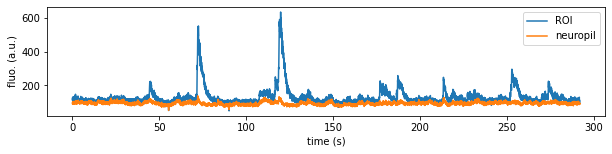

In [11]:
# let's load a datafile and look at the fluorescence
data = Data(TSeries_folders[3])
data.plot_raw(roi_index=1)

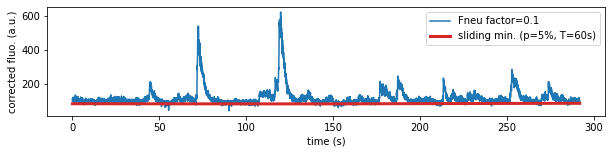

In [5]:
data.plot_corrected_raw(roi_index=1, neuropil_correction_factor=0.1)

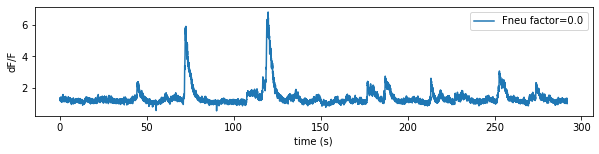

In [6]:
# plotting dF over F
data.plot_dFoF(roi_index=1, neuropil_correction_factor=0.)

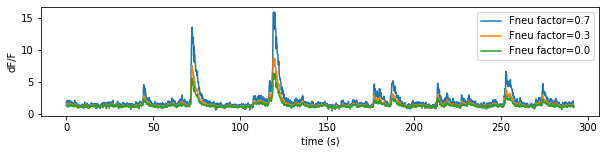

In [7]:
# looking at different dF over F for different correction factors
data.plot_dFoF(roi_index=1, factors=[0.7, 0.35, 0], subsampling=5)

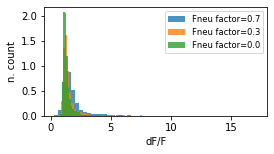

In [8]:
# histogram for that cell
data.plot_dFoF_hist(roi_index=1,factors=[0.7, 0.35, 0])

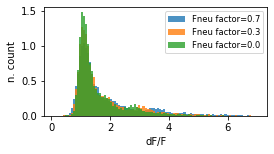

In [9]:
# for another cell + zoom features
data.plot_dFoF_hist(roi_index=10,factors=[0.7, 0.35, 0], bins=np.linspace(0.1, 7, 100))

Datafile: "/home/yann.zerlaut/UNPROCESSED/TSeries-12212020-0951-001" 
 neuropil-correction-factor=0.50
-> running loop over cells [...]
Datafile: "/home/yann.zerlaut/UNPROCESSED/TSeries-12212020-0951-001" 
 neuropil-correction-factor=0.00
-> running loop over cells [...]


Text(0, 0.5, 'dF/F')

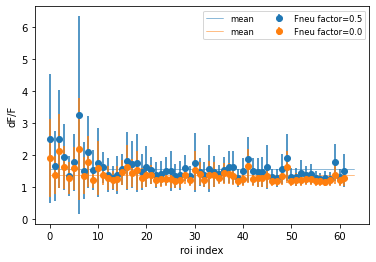

In [26]:
# mean and std for each cell
fig, ax = plt.subplots()
for i, factor in enumerate([0.5, 0]):
    means, stds = data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=factor, verbose=True)
    ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt='o',
                label='Fneu factor=%.1f' % factor, color=plt.cm.tab10(i))
    ax.plot([0,len(means)+1], np.mean(means)*np.ones(2), 
            lw=0.5, label='mean', color=plt.cm.tab10(i))
ax.legend(fontsize='small', ncol=2)
ax.set_xlabel('roi index')
ax.set_ylabel('dF/F')

### now looping over files

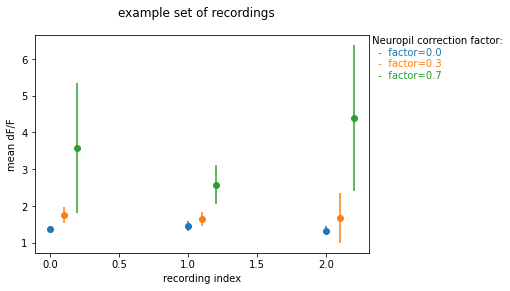

In [13]:
CORRECTION_FACTORS = [0, 0.35, 0.7]

def loop_over_folder_list(folder_list,
                          CORRECTION_FACTORS = [0, 0.35, 0.7],
                          with_fig=True, title=''):
    # mean and std for each cell
    if with_fig:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        
    MEAN_PER_RECORDING = {}
    for factor in CORRECTION_FACTORS:
        MEAN_PER_RECORDING[str(factor)] = []

    for t, df in enumerate(folder_list):
        try:
            data = Data(df)
            for i, factor in enumerate(CORRECTION_FACTORS):
                mean, std = data.get_mean_sem_dFoF_over_cells_safe(neuropil_correction_factor=factor,
                                                                  verbose=False)
                if with_fig:
                    ax.errorbar([t+.1*i], [mean], yerr=[std], fmt='o',
                                color=plt.cm.tab10(i))
                MEAN_PER_RECORDING[str(factor)].append(mean)
        except BaseException as be:
            print(be)
            print(' /!\ "%s" INVALID DATAFOLDER  ' % df)

    if with_fig:
        ax.annotate(' Neuropil correction factor:', (1,1), xycoords='axes fraction', va='top')
        for i, factor in enumerate(CORRECTION_FACTORS):
            ax.annotate((i+1)*'\n'+'   -  factor=%.1f' % factor, (1,1), 
                        xycoords='axes fraction', color=plt.cm.tab10(i), va='top')
        ax.set_xlabel('recording index')
        ax.set_ylabel('mean dF/F')                                   
    else:
        fig = None
        
    return MEAN_PER_RECORDING, fig
                      
MEAN_PER_RECORDING, fig = loop_over_folder_list(TSeries_folders[:3], title='example set of recordings')
# fig.savefig('fig.png')

In [14]:
print(MEAN_PER_RECORDING['0'])

[1.3672171072330428, 1.453966226958864, 1.3334082795289512]


In [15]:
print(MEAN_PER_RECORDING['0.7'])

[3.5772107149698287, 2.5843936810538435, 4.384948975289341]


### Computation time

In [16]:
%timeit -n 1 -r 1 data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=0.2, verbose=False)

24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
%timeit -n 1 -r 1 data.get_mean_sem_dFoF_over_cells_safe(neuropil_correction_factor=0.2, verbose=False)

13.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
